## Covid-19陽性者数の分析
### ①モンテカルロフィルタ（原系列にトレンド、周期性成分。状態ノイズにコーシー分布）
### ②カルマンフィルタ（対数変換系列にトレンド、周期性成分）

In [1]:
import numpy as np
import json
import requests
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import japanize_matplotlib
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# データのダウンロード
url = "https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json"
res = requests.get(url).json()

# 感染者数のデータをData Frameに返還
data = pd.DataFrame(res["patients_summary"]["data"])
# 日本語の列名は何かと不便なので，日付をdate，感染者数をnに変更
data = data.set_axis(["date", "n"], axis=1)
# 日付の文字列を変換
data.date = [datetime.datetime.strptime(d, "%Y-%m-%dT%H:%M:%S.000Z") for d in data.date.values]

In [2]:
data.set_index('date', inplace = True)
df = data
df.head(20)

,n
date,
2020-01-24 08:00:00,1
2020-01-25 08:00:00,1
2020-01-26 08:00:00,0
2020-01-27 08:00:00,0
2020-01-28 08:00:00,0
2020-01-29 08:00:00,0
2020-01-30 08:00:00,1
2020-01-31 08:00:00,0
2020-02-01 08:00:00,0


In [3]:
df.shape

(544, 1)

In [141]:
df= df.drop(df.index[-1])

In [142]:
df.shape

(541, 1)

In [4]:
df.tail(20)

,n
date,
2021-07-01 08:00:00,673
2021-07-02 08:00:00,660
2021-07-03 08:00:00,716
2021-07-04 08:00:00,518
2021-07-05 08:00:00,342
2021-07-06 08:00:00,593
2021-07-07 08:00:00,920
2021-07-08 08:00:00,896
2021-07-09 08:00:00,822


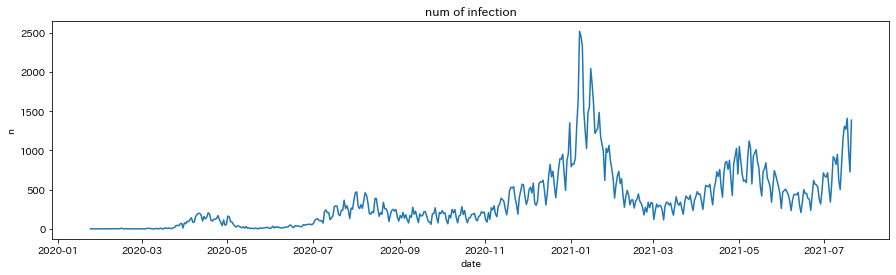

In [5]:
target=df['n']

fig = plt.figure(figsize=(15,4))
sns.lineplot(x=df.index,y=target).set_title('num of infection')
plt.show()

### 自己相関・偏自己相関・単位根の確認

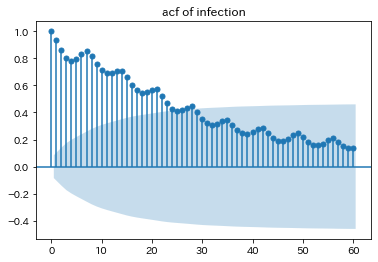

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(target, lags=60, title="acf of infection")
plt.show()

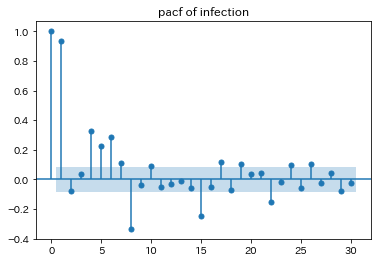

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(target, lags=30, title= "pacf of infection")
plt.show()

In [10]:
from statsmodels.tsa import stattools

adf = stattools.adfuller(target, regression='ctt')
print("<<CoVid-19のADF検定>>")
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
    ))

<<CoVid-19のADF検定>>
t値 : -3.60, p値 : 8.9%
データ数 : 521, 使用されたラグ数 : 18
検定統計量における棄却値 : 1%=-4.39, 5%=-3.84, 10%=-3.56


In [11]:
df_diff = df.diff().dropna()
df_diff = pd.DataFrame(df_diff)
df_diff.head()

,n
date,
2020-01-25 08:00:00,0.0
2020-01-26 08:00:00,-1.0
2020-01-27 08:00:00,0.0
2020-01-28 08:00:00,0.0
2020-01-29 08:00:00,0.0


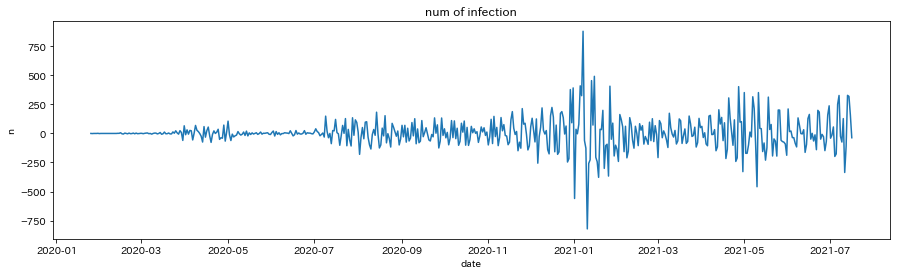

In [12]:
target = df_diff['n']

fig = plt.figure(figsize=(15,4))
sns.lineplot(x=target.index,y=target).set_title('num of infection')
plt.show()

In [13]:
adf = stattools.adfuller(target, regression='ctt')
print("<<CoVid-19のADF検定>>")
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
    ))

<<CoVid-19のADF検定>>
t値 : -4.53, p値 : 0.6%
データ数 : 521, 使用されたラグ数 : 17
検定統計量における棄却値 : 1%=-4.39, 5%=-3.84, 10%=-3.56


### １階の階差を取ったら定常になった。→感染者数はトレンドあり（ランダムウォーク）, F行列に[2,-1,1,0]の成分を作る

### 周期性の確認

In [14]:
target[-20:]

date
2021-06-27 08:00:00   -148.0
2021-06-28 08:00:00    -69.0
2021-06-29 08:00:00    159.0
2021-06-30 08:00:00    238.0
2021-07-01 08:00:00    -41.0
2021-07-02 08:00:00    -13.0
2021-07-03 08:00:00     56.0
2021-07-04 08:00:00   -198.0
2021-07-05 08:00:00   -176.0
2021-07-06 08:00:00    251.0
2021-07-07 08:00:00    327.0
2021-07-08 08:00:00    -24.0
2021-07-09 08:00:00    -74.0
2021-07-10 08:00:00    128.0
2021-07-11 08:00:00   -336.0
2021-07-12 08:00:00   -112.0
2021-07-13 08:00:00    328.0
2021-07-14 08:00:00    319.0
2021-07-15 08:00:00    159.0
2021-07-16 08:00:00    -37.0
Name: n, dtype: float64

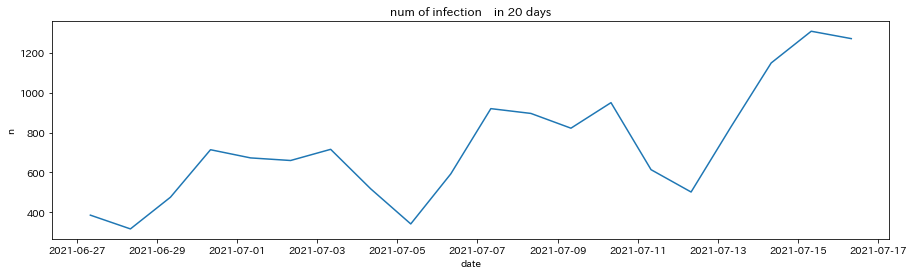

In [15]:
target=df['n']

fig = plt.figure(figsize=(15,4))
sns.lineplot(x=df[-20:].index,y=target[-20:]).set_title('num of infection　in 20 days')
plt.show()

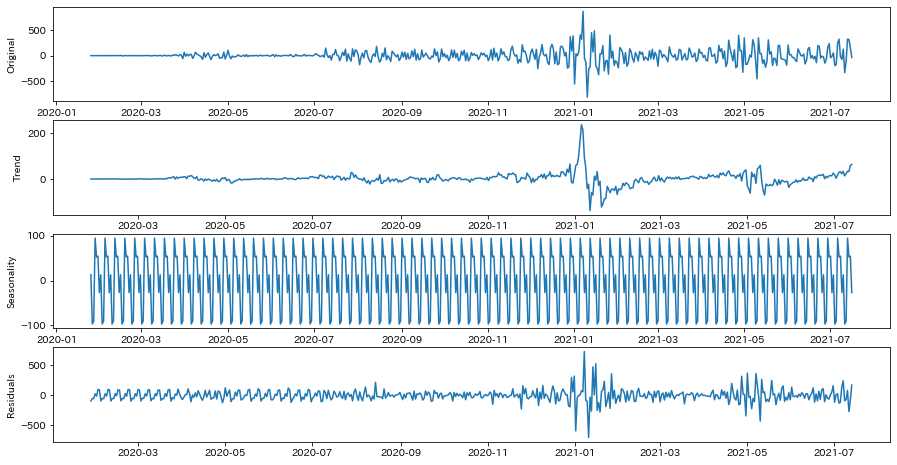

In [16]:
import statsmodels.api as sm
from statsmodels.tsa import stattools
# statsmodel のseasonal_decomposeで俯瞰データ出力　　　オリジナル、トレンド、季節性、残差

target =df_diff['n']
res = sm.tsa.seasonal_decompose(target, period=7)#７日周期

original = target # オリジナルデータ
trend = res.trend # トレンドデータ
seasonal = res.seasonal # 季節性データ
residual = res.resid # 残差データ

plt.figure(figsize=(15, 8)) # グラフ描画枠作成、サイズ指定

# オリジナルデータのプロット
plt.subplot(411) # グラフ4行1列の1番目の位置（一番上）
plt.plot(target)
plt.ylabel("Original")

# trend データのプロット
plt.subplot(412) # グラフ4行1列の2番目の位置
plt.plot(trend)
plt.ylabel('Trend')

# seasonalデータ のプロット
plt.subplot(413) # グラフ4行1列の3番目の位置
plt.plot(seasonal)
plt.ylabel('Seasonality')

# residual データのプロット
plt.subplot(414) # グラフ4行1列の4番目の位置（一番下）
plt.plot(residual)
plt.ylabel('Residuals')

plt.show()

In [17]:
print(res.resid)
residual = res.resid.dropna()
residual = pd.DataFrame(residual)

date
2020-01-25 08:00:00           NaN
2020-01-26 08:00:00           NaN
2020-01-27 08:00:00           NaN
2020-01-28 08:00:00    -94.506263
2020-01-29 08:00:00    -52.205096
                          ...    
2021-07-12 08:00:00    -80.703217
2021-07-13 08:00:00    169.208022
2021-07-14 08:00:00           NaN
2021-07-15 08:00:00           NaN
2021-07-16 08:00:00           NaN
Name: resid, Length: 539, dtype: float64


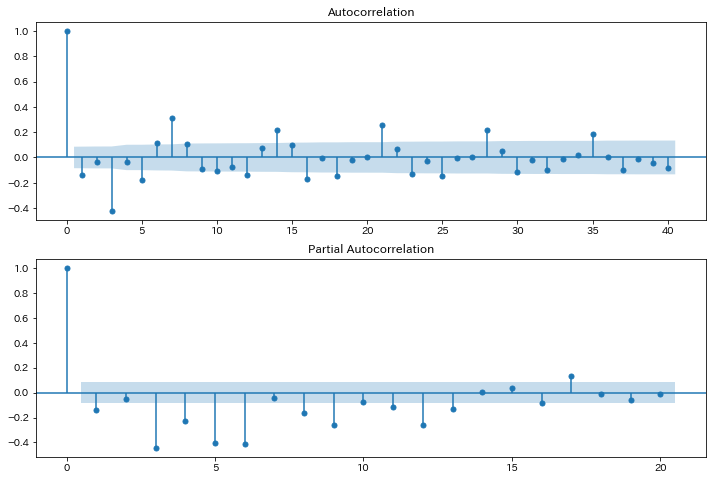

In [18]:
# 残差のチェック
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residual.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residual, lags=20, ax=ax2,method='ywm')

### 残差に周期性が残っているため、残差に対し更にdecompose

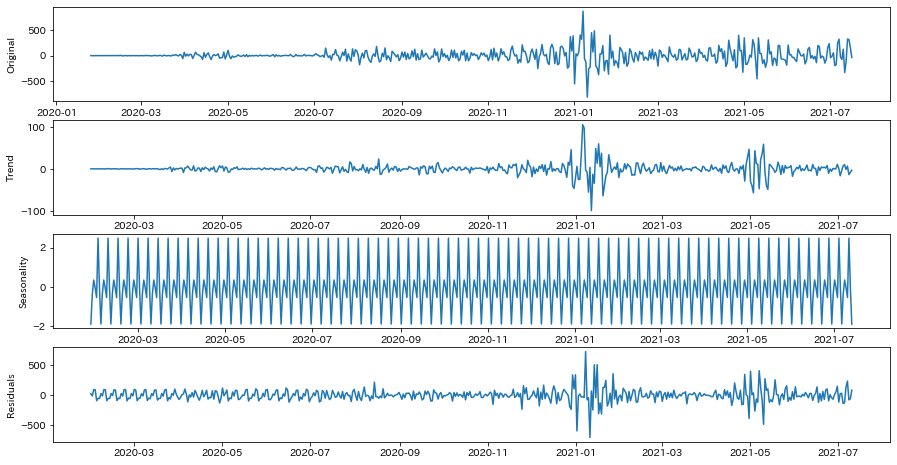

In [19]:
import statsmodels.api as sm
from statsmodels.tsa import stattools
# statsmodel のseasonal_decomposeで俯瞰データ出力　　　オリジナル、トレンド、季節性、残差

res = sm.tsa.seasonal_decompose(residual, period=7)

# res = sm.tsa.seasonal_decompose(passengers) # 解析結果は取得済み

original = residual # オリジナルデータ
trend = res.trend # トレンドデータ
seasonal = res.seasonal # 季節性データ
residual = res.resid # 残差データ

plt.figure(figsize=(15, 8)) # グラフ描画枠作成、サイズ指定

# オリジナルデータのプロット
plt.subplot(411) # グラフ4行1列の1番目の位置（一番上）
plt.plot(target)
plt.ylabel("Original")

# trend データのプロット
plt.subplot(412) # グラフ4行1列の2番目の位置
plt.plot(trend)
plt.ylabel('Trend')

# seasonalデータ のプロット
plt.subplot(413) # グラフ4行1列の3番目の位置
plt.plot(seasonal)
plt.ylabel('Seasonality')

# residual データのプロット
plt.subplot(414) # グラフ4行1列の4番目の位置（一番下）
plt.plot(residual)
plt.ylabel('Residuals')

plt.show()

In [20]:
print(res.resid)
residual = res.resid.dropna()
residual = pd.DataFrame(residual)

date
2020-01-28 08:00:00          NaN
2020-01-29 08:00:00          NaN
2020-01-30 08:00:00          NaN
2020-01-31 08:00:00    25.937539
2020-02-01 08:00:00   -12.298229
                         ...    
2021-07-09 08:00:00   -61.491032
2021-07-10 08:00:00    85.109935
2021-07-11 08:00:00          NaN
2021-07-12 08:00:00          NaN
2021-07-13 08:00:00          NaN
Name: resid, Length: 533, dtype: float64


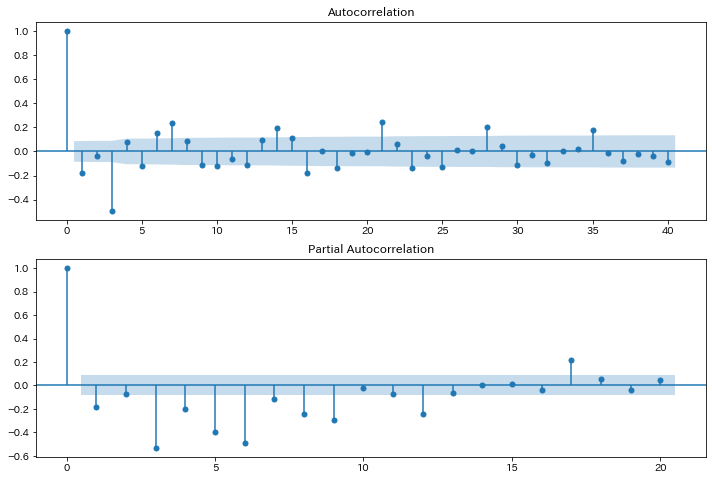

In [21]:
# 残差のチェック
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residual.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residual, lags=20, ax=ax2,method='ywm')

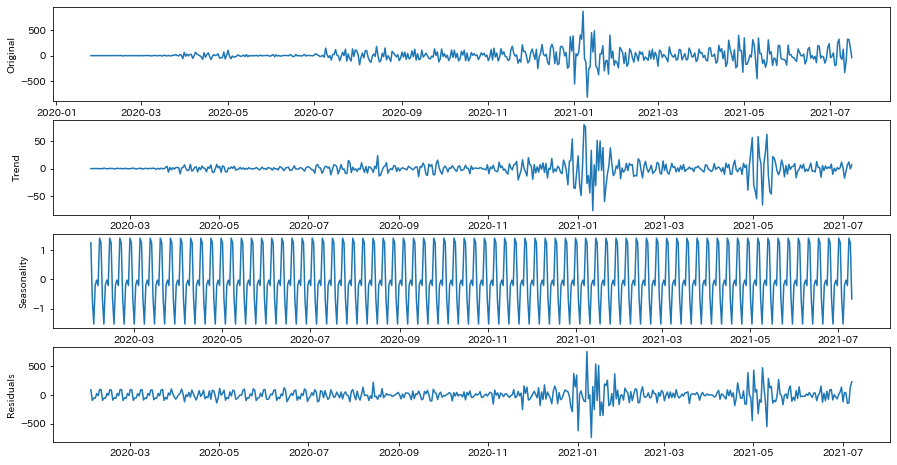

In [22]:
import statsmodels.api as sm
from statsmodels.tsa import stattools
# statsmodel のseasonal_decomposeで俯瞰データ出力　　　オリジナル、トレンド、季節性、残差

res = sm.tsa.seasonal_decompose(residual, period=7)

# res = sm.tsa.seasonal_decompose(passengers) # 解析結果は取得済み

original = residual# オリジナルデータ
trend = res.trend # トレンドデータ
seasonal = res.seasonal # 季節性データ
residual = res.resid # 残差データ

plt.figure(figsize=(15, 8)) # グラフ描画枠作成、サイズ指定

# オリジナルデータのプロット
plt.subplot(411) # グラフ4行1列の1番目の位置（一番上）
plt.plot(target)
plt.ylabel("Original")

# trend データのプロット
plt.subplot(412) # グラフ4行1列の2番目の位置
plt.plot(trend)
plt.ylabel('Trend')

# seasonalデータ のプロット
plt.subplot(413) # グラフ4行1列の3番目の位置
plt.plot(seasonal)
plt.ylabel('Seasonality')

# residual データのプロット
plt.subplot(414) # グラフ4行1列の4番目の位置（一番下）
plt.plot(residual)
plt.ylabel('Residuals')

plt.show()

In [23]:
print(res.resid)
residual = res.resid.dropna()
residual = pd.DataFrame(residual)

date
2020-01-31 08:00:00           NaN
2020-02-01 08:00:00           NaN
2020-02-02 08:00:00           NaN
2020-02-03 08:00:00     90.739427
2020-02-04 08:00:00    -92.775636
                          ...    
2021-07-06 08:00:00    137.125239
2021-07-07 08:00:00    228.338805
2021-07-08 08:00:00           NaN
2021-07-09 08:00:00           NaN
2021-07-10 08:00:00           NaN
Name: resid, Length: 527, dtype: float64


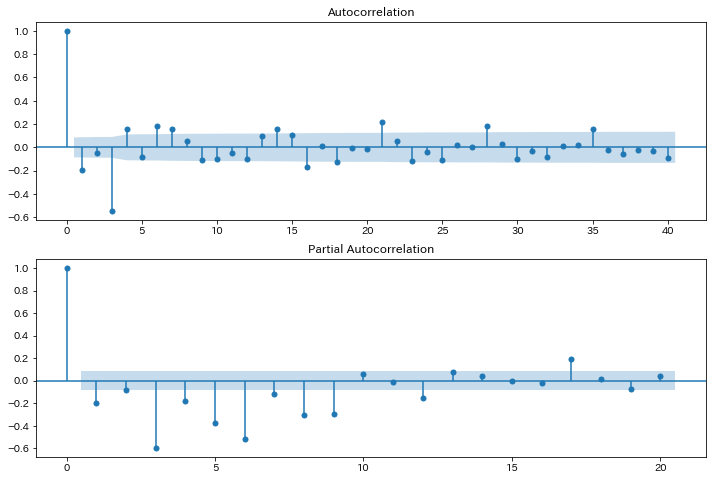

In [24]:
# 残差のチェック
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residual.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residual, lags=20, ax=ax2,method='ywm')

### 残差に２回decomposeをしてみたところ、自己相関は減るものの偏自己相関は増えるため、７日間の周期性１回のみを反映させる。　→F行列に6*6の成分を作る

In [238]:
#F行列（２階）
F2_infc = np.vstack((np.hstack((np.array([[2,-1],[1,0]]), np.zeros((2,6)))), np.hstack((np.zeros((6,2)),np.vstack((-np.ones((1,6)), np.hstack((np.eye(5),np.zeros((5,1))))))))))

## ①モンテカルロフィルタ（原系列にトレンド、周期性成分。状態ノイズにコーシー分布）

In [239]:
class ParticleFilter():
    """Particle Filter a.k.a. Monte Carlo Filter
    Parameters
    __________
    F: System model
    H: Observation model
    L: Likelihood function of observation model
    x0: initial particles
    dim: dimension of the state space
    N: number of particles
    """
    def __init__(self, F, H, L, x0, dim, N):
        # 初期化
        self.dim = dim#状態空間の次元
        self.F = F#システムモデル係数
        self.H = H#観測モデル係数
        self.L = L#観測の尤度
        self.N = N#粒子の数
        self.T = 0#時間
        self.M = 100
        
        # Filtered values
        self.particles = np.zeros((self.M, self.dim, self.N))#枠を作っておく（１００×次元数×粒子の数）
        self.particles[0] = x0#粒子の初期値
        
        # weights of particles
        self.weights = np.zeros((self.M, self.N))#枠を作っておく（１００×粒子の数）
        self.weights[0] = 1/N#１行目は粒子ウェイトを均等に割る
        
    """Prediction
    Parameters
    __________
    duation: default 1
    
    """
    def predict(self, duration=1):
        p_particles = np.zeros((duration, self.dim, self.N))
        particle = self.particles[self.T].copy()
        
        # 各時刻の予測を計算する
        for t in range(duration):
            # 1期先予測
            particle = self.F(particle)
            p_particles[t] = particle
        return p_particles
    
    """Filter
    Parameters
    __________
    y: observation
    
    """
    def filter(self, y):
        # 1期先予測
        particle = self.predict()
        
        # フィルタ分布・予測分布の格納用変数のサイズを超えたら
        # これらのサイズを拡張する
        self.T = self.T + 1
        if self.T >= self.particles.shape[0]:
            self.particles = np.concatenate((self.particles, np.zeros((self.M, self.dim, self.N))), 0)
            self.weights = np.vstack((self.weights, np.zeros((self.M, self.N))))
        
        # 重みの更新
        l = self.L(y, particle[0]) # 観測の対数尤度　-定数
        l = l - l.max()
        w = self.weights[self.T-1] * np.exp(l)
        self.weights[self.T] = w / w.sum()
        
        # 粒子の更新
        if True: # リサンプリングする場合
            idx = np.random.choice(np.arange(self.N), size=self.N, p=self.weights[self.T])
            self.particles[self.T] = particle[:,:,idx]
            self.weights[self.T] = 1/self.N
        else: # リサンプリングしない場合
                self.particles[self.T] = particle
                
    """Percentile of filter distribution
    Parameters
    __________
    p: percentile
    """
    def percentile(self, p):
        return np.percentile(self.particles, p, axis=2).transpose((1,0,2))
    
    """Percentile of observation
    Parameters
    __________
    p: percentile
    """
    def percentile_y(self, p):
        y_particles = self.H(self.particles[1:self.T+1])
        return np.percentile(y_particles, p, axis=2).transpose((1,0,2))
    
    """Percentile of prediction
    Parameters
    __________
    duration:
    p: percentile
    """
    def predict_percentile(self, duration, p):
        p_particles = self.predict(duration)
        y_particles = self.H(p_particles)
        
        return y_particles.mean(2), np.percentile(y_particles, p, axis=2).transpose((1,0,2))
    
    def mean(self):
        y_particles = self.H(self.particles[1:self.T+1])
        return np.median(y_particles,2), self.particles[1:self.T+1].mean(2)
    
"""Sequential Filter
Parameters
__________
f: Filter object
y: observation
"""
def seq_filter(f, y):
    T = y.shape[0]
    # 逐次的にフィルタを実行
    for t in range(T):
        f.filter(y[t])
    return f

"""Plot filter results
Parameters
__________
f: Filter object
y: observation
y_t: expectation of observation
p: percentile for visualization
ylim: range of y-axis
"""
def filter_plot(f,y,y_t, p, ylim, duration, state_idx):
    # フィルタ分布の95%区間
    q = f.percentile(p)
    # フィルタ分布から求めた観測の分布の95%区間
    q_y = f.percentile_y(p)
    # 残り10点（41-50）の予測分布の95%区間
    p_mu, p = f.predict_percentile(duration, p)
    # フィルタ分布の期待値
    y_mu, f_mu = f.mean()
        
    # 結果の描画
    fig = plt.figure(figsize=(16, 12))
    # 横に2枚並べてプロット
    # 左側は，観測値yに関するフィルタ結果と予測を描画
    ax = fig.add_subplot(211)
    # 95%区間全体を描画すると広すぎるのでy軸の範囲をあらかじめ限定する
    ax.set_ylim(ylim)
    
    # 観測値yの期待値
    ax.plot(y_mu)
    # 観測値yの95%区間
    ax.fill_between(np.arange(f.T), q_y[:,0,0], q_y[:,1,0], alpha=0.3)
    # 観測値yの予測の期待値
    #print(np.arange(f.T,len(y)))#530-539
    ax.plot(np.arange(f.T,len(y)), p_mu)
    # 観測値yの予測の共分散
    ax.fill_between(np.arange(f.T,len(y)), p[:,0,0], p[:,1,0], alpha=0.3)#fill_betweenは２つの関数の間を塗りつぶす
    # 観測値yの真の値を折れ線で表示
    ax.plot(np.arange(len(y_t)),y_t)
    # 実際に観測されたyを点で表示
    ax.scatter(np.arange(len(y)), y)
    
    # 右側はトレンド成分と季節成分の推定結果を描画
    ax2 = fig.add_subplot(212)
    # 95%区間全体を描画すると広すぎるのでy軸の範囲をあらかじめ限定する
    #ax2.set_xlim(len(y))
    ax2.set_ylim(ylim)
    for i in state_idx:
        # 成分（状態変数の最初の要素）の95%区間
        ax2.fill_between(np.arange(f.T), q[1:f.T+1,0,i], q[1:f.T+1,1,i], alpha=0.3)
        # 成分の期待値
        ax2.plot(f_mu[:,i])
    # 真のyを折れ線で表示
    ax2.plot(np.arange(len(y_t)-10),y_t[:f.T])#-予測の期間
    # 観測されたyを点で表示
    ax2.scatter(np.arange(f.T), y[:f.T])


In [88]:
N = 10000
print(np.array([[1,0,1]]))
print(np.zeros((1,8)))
print(np.hstack((np.array([[1,0,1]]),np.zeros((1,8)))))
print(np.tile(np.log(0.1), (3,N)))

[[1 0 1]]
[[0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[-2.30258509 -2.30258509 -2.30258509 ... -2.30258509 -2.30258509
  -2.30258509]
 [-2.30258509 -2.30258509 -2.30258509 ... -2.30258509 -2.30258509
  -2.30258509]
 [-2.30258509 -2.30258509 -2.30258509 ... -2.30258509 -2.30258509
  -2.30258509]]


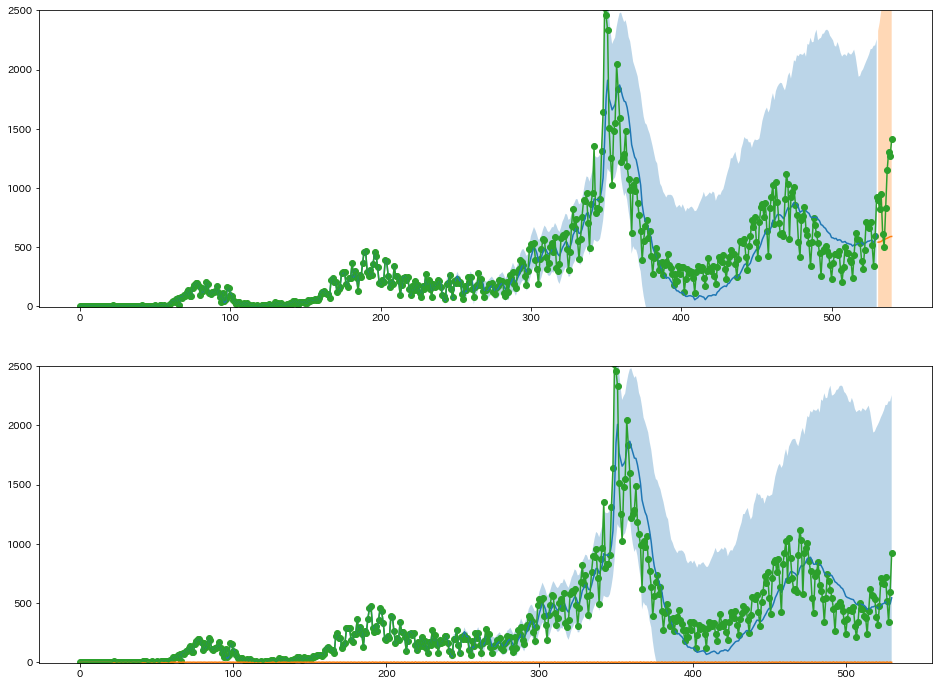

In [243]:
y =  df['n']

def main():
    # 以降のテストのため，乱数の種を固定
    np.random.seed(seed=10000)
    
    #粒子の数
    N = 10000

    # システムモデルの行列F
    F_mat = F2_infc#8*8

    #システムモデル(Pはウェイト？)
    def F2(p):
        p2 = p
        p2[:8] = np.matmul(F_mat, p[:8])#[:9]は、0〜8までの9要素
        p2[8:] += np.random.normal(scale=0.1, size=(3,N))#np.logを3×N(粒子数)　※粒子の初期値に対応、12次元
        p2[0] = p2[0] + np.random.standard_cauchy(size=(1, p.shape[1])) * np.exp(0.5*p2[8])#システムノイズ（トレンド成分）scaleは標準偏差,p2[9]はおそらくパラメータ
        p2[2] = p2[2] + np.random.normal(size=(1, p.shape[1]), scale=np.exp(0.5*p2[9]))#システムノイズ（季節成分）,p2[10]はおそらくパラメータ
        return p2

    #観測モデルの行列
    H_mat = np.hstack((np.array([[1,0,1]]),np.zeros((1,5))))#1×9, [1,0,1]はトレンド成分と季節成分に対応？

    #観測モデル
    def H2(p): 
        y = np.zeros((p.shape[0], H_mat.shape[0], p.shape[2]))#pは100×次元数×N（粒子数）
        for t in range(p.shape[0]):
            y[t] = np.matmul(H_mat, p[t,:8])
        return y

    #観測モデルの尤度
    L = lambda y,p : -0.5 * (y - np.matmul(H_mat, p[:8]))**2 / np.exp(p[10])#p[11]はおそらくパラメータ

    #粒子の初期値
    x0 = np.vstack((np.random.normal(scale=0.01, size=(8,N)), #平均1,9×N(粒子数)の正規分布
                    np.tile(np.log(0.01), (3,N))))#（おそらくパラメータ（３ノイズ））np.logを3×N(粒子数)　※全部で１２×N
    
    #粒子フィルタ
    pf = ParticleFilter(F2, #システムモデル
                        H2, #観測モデルの行列
                        L, #観測モデルの尤度
                        x0, #粒子の初期値
                        11, #次元数
                        N)#粒子の数
    
    #逐次フィルタ
    seq_filter(pf, y[:531])#ｙの期間-予測期間, pfは粒子フィルタ

    filter_plot(pf, #フィルタオブジェクト（青折れ線：観測値の期待値, プロット及び折れ線:観測値）
                y, #観測値
                y,#真の値
                np.array([2.5, 97.5]),#パーセンタイル区間 
                [-5,2500], #y軸の範囲
                10, #予測期間
                [0,2])#状態の成分？
                #y_t, np.array([2.5, 97.5]), [-5,10], 10, [0,2])

if __name__ == '__main__':
    main()

## ②カルマンフィルタ（対数変換系列にトレンド、周期性成分）

In [144]:
#感染者数"0"があるため、＋１をしたのち対数化
df_log = np.log(df+1)

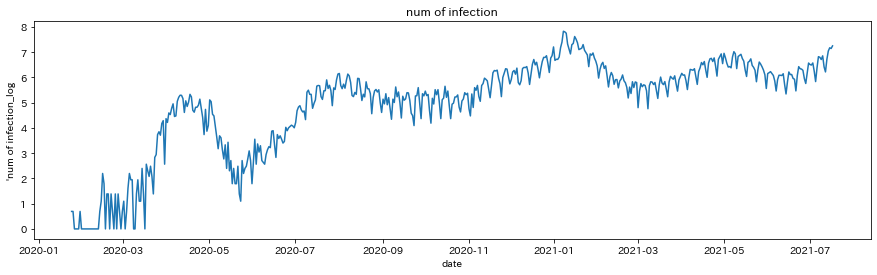

In [196]:
target=df_log['n']

fig = plt.figure(figsize=(15,4))
sns.lineplot(x=df.index,y=target).set_title('num of infection')
plt.ylabel("'num of infection_log")
plt.show()

In [146]:
df_log.tail()
df_log.shape

(541, 1)

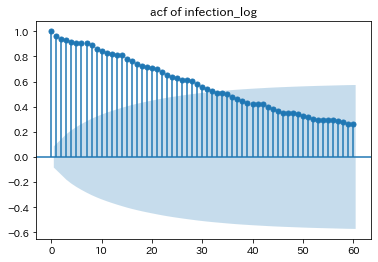

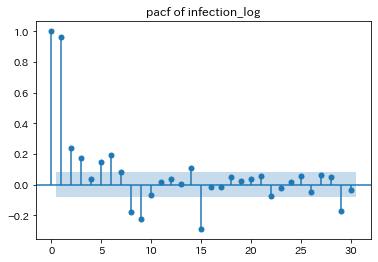

In [197]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(target, lags=60, title="acf of infection_log")
plot_pacf(target, lags=30, title= "pacf of infection_log")
plt.show()

In [151]:
from statsmodels.tsa import stattools

adf = stattools.adfuller(target, regression='ctt')
print("<<CoVid-19のADF検定>>")
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
    ))

<<CoVid-19のADF検定>>
t値 : -4.56, p値 : 0.5%
データ数 : 524, 使用されたラグ数 : 16
検定統計量における棄却値 : 1%=-4.39, 5%=-3.84, 10%=-3.56


### 対数化した感染者数は、自己相関は高いが、単位根ではない。

In [153]:
df_log_diff = df_log.diff().dropna()
df_log_diff = pd.DataFrame(df_log_diff)
df_log_diff.head()

,n
date,
2020-01-25 08:00:00,0.000000
2020-01-26 08:00:00,-0.693147
2020-01-27 08:00:00,0.000000
2020-01-28 08:00:00,0.000000
2020-01-29 08:00:00,0.000000


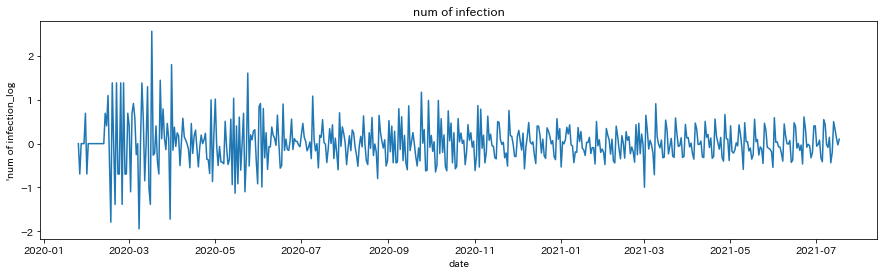

In [155]:
target=df_log_diff['n']

fig = plt.figure(figsize=(15,4))
sns.lineplot(x=df_log_diff.index,y=target).set_title('num of infection')
plt.ylabel("'num of infection_log")
plt.show()

<Figure size 1080x288 with 0 Axes>

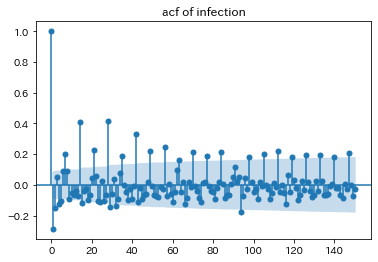

In [157]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(target, lags=150, title="acf of infection")
plt.show()

### 差分を取った感染者数の対数については、２週間ごとの自己相関が高い。１週間ごとにも自己相関あり。

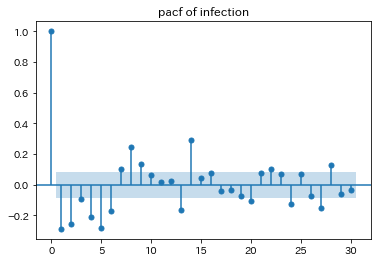

In [158]:
plot_pacf(target, lags=30, title= "pacf of infection")
plt.show()

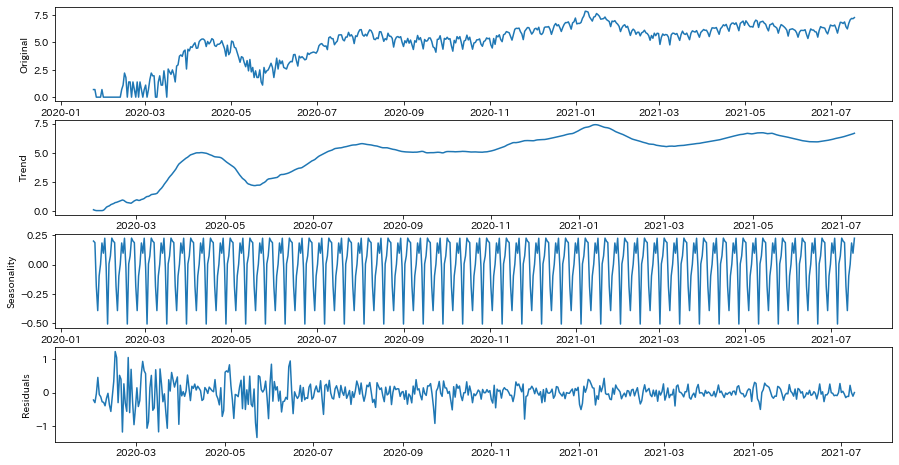

In [202]:
import statsmodels.api as sm
from statsmodels.tsa import stattools
# statsmodel のseasonal_decomposeで俯瞰データ出力　　　オリジナル、トレンド、季節性、残差

res = sm.tsa.seasonal_decompose(target, period=14)#７日周期

original = target # オリジナルデータ
trend = res.trend # トレンドデータ
seasonal = res.seasonal # 季節性データ
residual = res.resid # 残差データ

plt.figure(figsize=(15, 8)) # グラフ描画枠作成、サイズ指定

# オリジナルデータのプロット
plt.subplot(411) # グラフ4行1列の1番目の位置（一番上）
plt.plot(target)
plt.ylabel("Original")

# trend データのプロット
plt.subplot(412) # グラフ4行1列の2番目の位置
plt.plot(trend)
plt.ylabel('Trend')

# seasonalデータ のプロット
plt.subplot(413) # グラフ4行1列の3番目の位置
plt.plot(seasonal)
plt.ylabel('Seasonality')

# residual データのプロット
plt.subplot(414) # グラフ4行1列の4番目の位置（一番下）
plt.plot(residual)
plt.ylabel('Residuals')

plt.show()

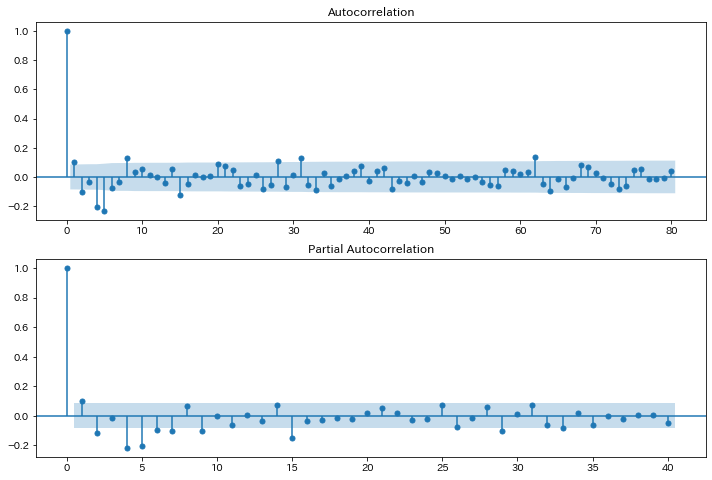

In [203]:
residual = res.resid.dropna()
residual = pd.DataFrame(residual)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residual.values.squeeze(), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residual, lags=40, ax=ax2,method='ywm')

### 残差には有意な自己相関・偏自己相関あり。

In [191]:
class KalmanFilter():

    """Kalman Filter Parameters"""
    def __init__(self, F, H, R, x0, sgm0):#コンストラクタ（初期化）
        #初期化
        self.dim = H.shape[1]#観測の行列の列数
        self.F = F#F:system model（状態）
        self.H = H#Observation matrix（観測の行列）
        self.R = R#Covariance matrix of observation noise（観測のノイズ共分散行列）
        self.M = 100
        self.T = 0
        
        # Filtered values
        #メモリ負荷節減のために枠を作成(平均、100×H観測の行列の列数)
        self.mu = np.zeros((self.M, self.dim))
        
        #x0:initial expected value of state variables（状態）
        self.mu[0] = x0
        
        #100×H観測の行列の列数
        self.sgm = np.zeros((self.M, self.dim, self.dim))
        
        #sgm0:initial covariance matrix of state variables（状態）
        self.sgm[0] = sgm0
        
        # log liklihood
        self.log_likelihood = 0.0
        
        
    """Prediction Parameters/// duration: default 1"""
    def predict(self, duration=1):
        
        #予測された期待値の枠（1×観測の行列の列数）
        p_mu = np.zeros((duration, self.dim))
        
        #予測された分散共分散の枠（1×観測の行列の列数×観測の行列の列数）
        p_sgm = np.zeros((duration, self.dim, self.dim))
        
        #現時刻のフィルタ分布
        mu = self.mu[self.T]
        sgm = self.sgm[self.T]
        
        #各時刻の予測を計算する
        for t in range(duration):
            #１期先予測
            mu, sgm = self.F(mu, sgm)#状態の期待値、分散
            p_mu[t] = mu#更新？？
            p_sgm[t] = sgm
        return p_mu, p_sgm
   
    """Filter Parameters
    /// y: observation"""
    def filter(self, y):
        #yは現時点での観測
        #1期先予測
        p_mu, p_sgm = self.predict()#predict関数を起動
        
        #フィルタ分布、予測分布の格納用変数のサイズを超えたら
        # これらのサイズを拡張する
        self.T = self.T + 1
        if self.T >= self.mu.shape[0]:#Tがmuの行数１００を超えたら
            self.mu = np.vstack((self.mu, np.zeros((self.M, self.dim))))#mu行列の下に100×H観測の行列の列数を追加
            self.sgm = np.concatenate((self.sgm,np.zeros((self.M, self.dim,self.dim))), 0)#sgm行列にゼロ行列を追加
        
        # 観測値と１期前時点から予測される観測の期待値の誤差
        err = y - np.matmul(self.H, p_mu[0])
        v = np.matmul(self.H, p_sgm[0])#H*sgmを先に計算している
        
        # 予測の期待値及び共分散の補正値を計算
        c =  np.matmul(p_sgm[0], self.H.T)
        
        # 逆行列を直接計算せずに，連立方程式の解を求める（solve）
        c =  np.matmul(c, np.linalg.solve(self.R + np.matmul(np.matmul(self.H,  p_sgm[0]), self.H.T),
                                          np.hstack((np.expand_dims(err,1),v))))
        
        # 補正値を期待値と共分散に加えてフィルタ分布を得る
        self.mu[self.T] = p_mu[0] + c[:,0]#フィルタ分布の期待値
        self.sgm[self.T] = p_sgm[0] - c[:,1:]#fフィルタ分布の共分散
        
       # 対数尤度の更新
        y_sgm = np.matmul(np.matmul(self.H, p_sgm[0]), self.H.T) + self.R#観測システムの分散共分散（２次形式＋観測ノイズ）
        self.log_likelihood -= 0.5 * (np.linalg.slogdet(y_sgm)[1] + np.dot(err, np.linalg.solve(y_sgm, err)))
        #slogdet[1]はオーバーフロー対策の行列式の根（自然対数の絶対値）

    """Percentile of normal distribution Parameters
    _________
    mu: matrix of expectation values (size: T X D)
    sgm: array of covariance matrices (size: T X D X D)
    p: percentile
    """   
    def percentile_norm(self, mu, sgm, p):#正規分布の区間をまとめている
        # 標準正規分布のパーセンタイル点
        c = np.expand_dims(norm.ppf(p),1)
        # 各時刻の分布（muの各行）のパーセンタイル点を求める
        q = np.zeros((mu.shape[0],len(p),mu.shape[1]))
        for t in range(mu.shape[0]):
            #各変数の標準偏差（2次元の配列　[[]]）
            s = np.atleast_2d(np.sqrt(np.diag(sgm[t])))#np.diag：対角成分の抽出
            # 各変数のパーセンタイル（標準偏差×標準偏差のパーセンタイル点）
            q[t] = mu[t] + np.matmul(c,s)
        return q
    
    """Estimate the distribution of observation variables from that of state variables
    Parameters（状態変数パラの分布から観測変数の分布を推定）
    __________
    mu: matrix of expected values of state variables（状態変数の期待値の「行列」）
    sgm: array of covariance matrices of state variables（状態変数の共分散行列の「配列」）    
    """
        
    def estimate_y(self,mu,sgm):
        # yの分布を求める期間
        T = mu.shape[0]
        # 観測yの期待値: 観測行列の係数を状態変数の期待値にかける
        y_mu = np.matmul(mu, self.H.T)
        
        # 観測yの共分散（期間×期待値の列数×期待値の列数）
        y_sgm = np.zeros((T, y_mu.shape[1], y_mu.shape[1]))
        for t in range(T):
            #状態変数の共分散の両側から観測行列Hをかけて観測yの共分散を得る
            y_sgm[t] = np.matmul(np.matmul(self.H,sgm[t]), self.H.T)
            
        return y_mu, y_sgm
    
    """Percentile of filter distribution（フィルタ分布のパーセンタイル）
    Parameters
    __________
    p: percentile
    """
        
    def percentile(self,p):
        return self.percentile_norm(self.mu, self.sgm, p)
    
    """Percentile of observation（観測のパーセンタイル、長期）
    Parameters
    __________
    p: percentile
    """
    
    def percentile_y(self, p):
        y_mu, y_sgm = self.estimate_y(self.mu[1:self.T+1],
                                     self.sgm[1:self.T+1])#1〜求める期間+1までの期待値と共分散
        return self.percentile_norm(y_mu, y_sgm, p)
    
    """Percentile of prediction（観測（予測）のパーセンタイル）
    Parameters
    __________
    duration:
    p: percentile
    """
    def predict_percentile(self, duration, p):
        # 状態変数の予測分布の期待値と共分散
        p_mu, p_sgm = self.predict(duration)
        # 観測値（観測ノイズを除く）の予測の期待値と共分散
        y_mu, y_sgm = self.estimate_y(p_mu, p_sgm)
        return y_mu, self.percentile_norm(y_mu, y_sgm, p)
    
    def mean(self):
        y_mu, _ = self.estimate_y(self.mu[1:self.T+1], 
                                      self.sgm[1:self.T+1])
        return y_mu, self.mu[1:self.T+1]
    
"""Sequential Filter（逐次フィルタ）
Parameters
__________
f: Filter object
y: observation
"""
def seq_filter(f,y):
    T = y.shape[0]
    # 逐次的にフィルタを実行
    for t in range(T):
        f.filter(y[t])
    return f

"""Plot filter results
Parameters
__________
f: Filter object
y: observation
y_t: expectation of observation
p: percentile for visualization
ylim: range of y-axis
"""
def filter_plot(f,y,y_t, p, ylim, duration, state_idx):
    # フィルタ分布の95%区間
    q = f.percentile(p)
    # フィルタ分布から求めた観測の分布の95%区間
    q_y = f.percentile_y(p)
    # 残り10点（41-50）の予測分布の95%区間
    p_mu, p = f.predict_percentile(duration, p)
    # フィルタ分布の期待値
    y_mu, f_mu = f.mean()
        
    fig = plt.figure(figsize=(16, 12))
    # 横に2枚並べてプロット
    # 左側は，観測値yに関するフィルタ結果と予測を描画
    ax = fig.add_subplot(211)
    # 95%区間全体を描画すると広すぎるのでy軸の範囲をあらかじめ限定する
    ax.set_ylim(ylim)
    
    # 観測値yの期待値
    ax.plot(y_mu)
    # 観測値yの95%区間
    ax.fill_between(np.arange(f.T), q_y[:,0,0], q_y[:,1,0], alpha=0.3)
    # 観測値yの予測の期待値
    #print(len(y))
    ax.plot(np.arange(f.T,len(y)), p_mu)
    # 観測値yの予測の共分散
    ax.fill_between(np.arange(f.T,len(y)), p[:,0,0], p[:,1,0], alpha=0.3)
    # 観測値yの真の値を折れ線で表示
    ax.plot(np.arange(len(y_t)),y_t)#こいつが犯人
    # 実際に観測されたyを点で表示
    ax.scatter(np.arange(len(y)), y)
    
    # 右側はトレンド成分と季節成分の推定結果を描画
    ax2 = fig.add_subplot(212)
    # 95%区間全体を描画すると広すぎるのでy軸の範囲をあらかじめ限定する
    ax2.set_ylim(ylim)
    for i in state_idx:
        # 成分（状態変数の最初の要素）の95%区間
        ax2.fill_between(np.arange(f.T), q[1:f.T+1,0,i], q[1:f.T+1,1,i], alpha=0.3)
        # 成分の期待値
        ax2.plot(np.arange(len(f_mu)),f_mu[:,i])#おそらくこいつが犯人
    # 真のyを折れ線で表示
    ax2.plot(np.arange(len(y_t[:f.T])),y_t[:f.T])#おそらくこいつが犯人
    # 観測されたyを点で表示
    ax2.scatter(np.arange(f.T), y[:f.T])

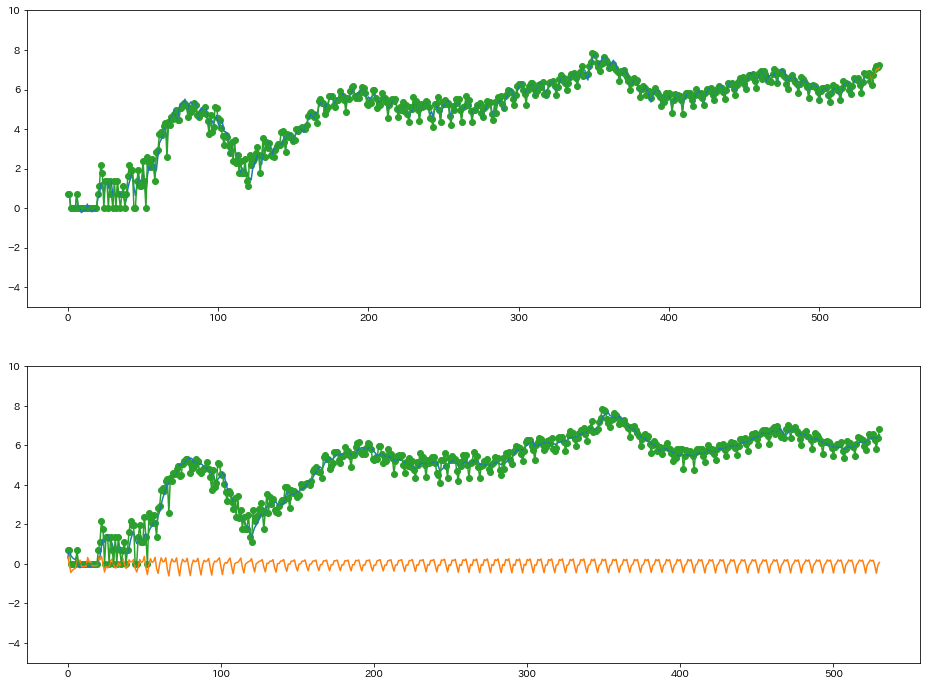

In [248]:
from scipy.stats import norm
from scipy.optimize import minimize

def main():
    # 以降のテストのため，乱数の種を固定
    np.random.seed(seed=10000)

    """カルマンフィルタ（ トレンド　＋　季節成分　＋　ランダムウォーク）"""    
    y =  df_log['n']

    F_mat = F2_infc#9*9

    # 最尤推定
    # 指定したシステムノイズ，観測ノイズの下で負の対数尤度を計算する関数
    # params: ①季節成分のシステムノイズの分散，②トレンド成分のシステムノイズの分散，③観測ノイズの分散

    def neg_log_likelihood(params):# システムノイズの共分散
        Q = np.zeros((8,8))#おそらく上記のF_matのサイズに合わせている
        Q[0,0] = np.exp(params[0])#②
        Q[2,2] = np.exp(params[1])#①

        F = lambda mu,sgm : (np.matmul(F_mat, mu), Q+np.matmul(np.matmul(F_mat, sgm), F_mat.T))
        # カルマンフィルタオブジェクトの生成
        kf = KalmanFilter(F, # 上で定義したシステムモデル
                          np.hstack((np.array([[1,0,1]]),np.zeros((1,5)))), # H（観測モデル）
                          np.exp(params[2]), # R（③）
                          np.zeros((8,)),  # 初期状態の期待値
                          np.eye(8)*10 # 初期状態の共分散)
                          )
        seq_filter(kf, y[:531])
        return -kf.log_likelihood

    res = minimize(neg_log_likelihood, [np.log(0.1), np.log(0.1), np.log(0.1)])

    # システムノイズの共分散
    Q = np.zeros((8,8))
    Q[0,0] = np.exp(res.x[0])#最尤推定された②トレンド成分のシステムノイズの分散
    Q[2,2] = np.exp(res.x[1])#最尤推定された①季節成分のシステムノイズの分散

    # システムモデル：現時点の期待値と共分散から1期先の分布の期待値と共分散を得る関数
    F = lambda mu,sgm : (np.matmul(F_mat, mu), Q+np.matmul(np.matmul(F_mat, sgm), F_mat.T))#期待値、共分散

    # カルマンフィルタオブジェクトの生成
    kf = KalmanFilter(F, # 上で定義したシステムモデル
                      np.hstack((np.array([[1,0,1]]),np.zeros((1,5)))), # H（観測モデル係数）
                      np.exp(res.x[2]), # R（最尤推定された観測モデルのノイズ）
                      np.zeros((8,)),  # 初期状態の期待値
                      np.eye(8)*10 # 初期状態の共分散)
                      )
    # 最初の40点についてフィルタを実行
    seq_filter(kf, y[:531])

    filter_plot(kf, y, y, np.array([2.5, 97.5]), [-5,10], 10, [0,2])    
    
if __name__ == '__main__':
    main()

### 対数変換後の系列に対するカルマンフィルタは、かなりフィットしたモデルとなることが確認できた。